In [ ]:
import os
import cv2
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision.transforms.functional as F

from rtdetr import RTDETR, get_valid_transforms, RTDETRPostProcessor, get_label_to_name

In [2]:
DEVICE = "cpu"
CHECKPOINT_PATH = "./saved/rtdetr_r18_50.pth"
CONFIG_PATH = "./rtdetr_r18.json"
cfg = json.load(open(CONFIG_PATH, "r"))

In [3]:
model = RTDETR(
    num_classes = cfg['num_classes'],
    backbone_model = cfg['backbone_model'],
    hidden_dim = cfg['hidden_dim'], 
    nhead = cfg['nhead'], 
    ffn_dim = cfg['ffn_dim'], 
    num_encoder_layers = cfg['num_encoder_layers'],
    expansion_factor= cfg['expansion_factor'],
    aux_loss = cfg['aux_loss'],
    num_queries = cfg['num_queries'],
    num_decoder_points = cfg['num_decoder_points'],
    num_denoising = cfg['num_denoising'],
    num_decoder_layers = cfg['num_decoder_layers'],
    dropout = cfg['dropout'],
    multi_scale= cfg['multi_scale'],
    num_bottleneck_blocks= cfg['num_bottleneck_blocks'],
)
checkpoint = torch.load(CHECKPOINT_PATH, map_location="cpu", weights_only=True)
model.load_state_dict(checkpoint)
model.to(DEVICE)
model.eval()

RTDETR(
  (backbone): BackBone(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [4]:
file_names = []
for file in os.listdir("./data/val2017/"):
    if file.endswith(".jpg"):
        file_names.append(file)

print(len(file_names))

5000


In [5]:
transform = get_valid_transforms()
label_to_name = get_label_to_name("./data/annotations/instances_val2017.json")
label_to_color = json.load(open("./coco_colors.json", "r"))
output_processor = RTDETRPostProcessor(num_classes=cfg['num_classes'], num_queries=cfg['num_queries']) 

In [ ]:
def plot_coco_image(image, target, label_to_name, label_to_color):
    """
    Plot an image with normalized center-format (cx, cy, w, h) boxes and labels.
    Args:
        image (PIL.Image or Tensor): The input image (PIL or Tensor in [0, 1]).
        target (dict): A dictionary with 'boxes' (in cx, cy, w, h normalized format), 'labels' and 'scores'.
        label_to_name (dict): Maps label integers to human-readable names.
        label_to_color (list): Maps label integers to rgb color.
    """
    # Convert tensor image to PIL if needed
    if isinstance(image, torch.Tensor):
        image = F.to_pil_image(image)

    H, W, _ = image.shape  # width, height
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    boxes = target['boxes']
    labels = target['labels']
    scores = target["scores"]

    for i in range(len(boxes)):
        label = labels[i].item()
        color = label_to_color[label]
        color = [c/255 for c in color]
        fill_color = color + [0.25]

        cx, cy, w, h = boxes[i].tolist()
        # Convert normalized cx, cy, w, h to pixel x_min, y_min, w, h
        box_w = w * W
        box_h = h * H
        x_min = (cx * W) - (box_w / 2)
        y_min = (cy * H) - (box_h / 2)

        # Draw rectangle
        rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=2, edgecolor=color, facecolor=fill_color)
        ax.add_patch(rect)

        # Draw label
        text = label_to_name.get(label, str(label))
        text += f" : {scores[i].item():.02f}"
        ax.text(x_min, y_min - 5, text, fontsize=12, color='white', bbox=dict(facecolor=color, alpha=0.5, pad=1))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

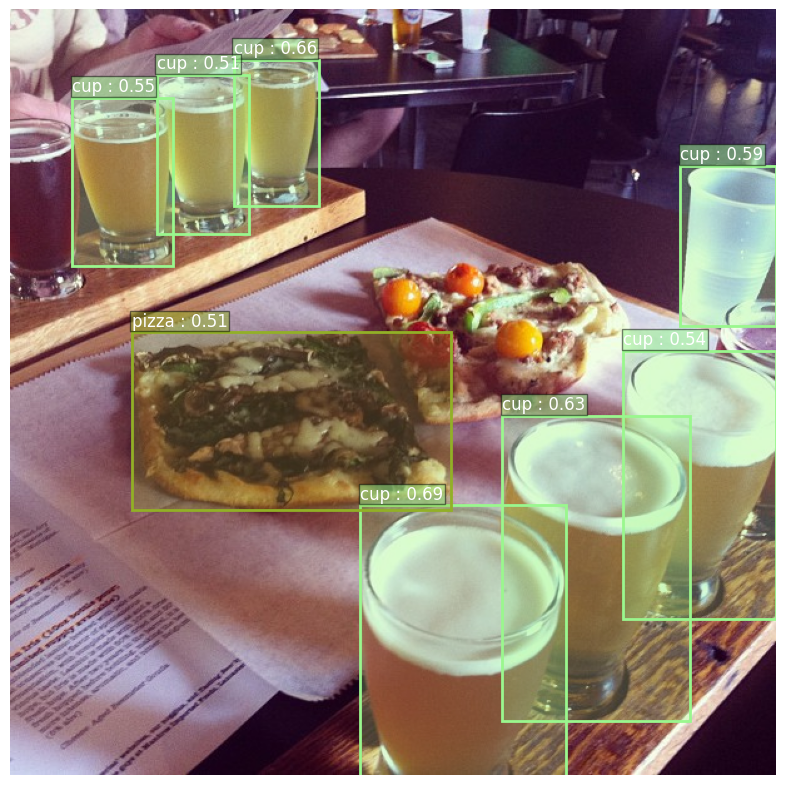

In [61]:
idx = random.randint(0, len(file_names)-1)
image = cv2.imread("./data/val2017/" + file_names[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = transform(image).unsqueeze(0).to(DEVICE)

out = model(img)
processed = output_processor(out, top_k=100, score_thresh=0.5)
plot_coco_image(image, processed[0], label_to_name, label_to_color)